In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from influenza_USA.NC_forecasts.utils import get_NC_influenza_data

## Forecast figure 

In [2]:
# settings
season = '2023-2024'
filename = '2023-12-30-JHU_IDD-hierarchSIM.csv'
start_visualisation = datetime(int(season[0:4]), 11, 1)
# load in prediction
simout = pd.read_csv(filename)
simout['reference_date'] = pd.to_datetime(simout['reference_date'])
# get reference date
stop_data_train = simout['reference_date'].unique()[0] - timedelta(weeks=1)
# load training and validation data
data_train = get_NC_influenza_data(start_visualisation, stop_data_train, season)['H_inc']*7
data_forecast = get_NC_influenza_data(stop_data_train+timedelta(weeks=1), stop_data_train+timedelta(weeks=4), season)['H_inc']*7

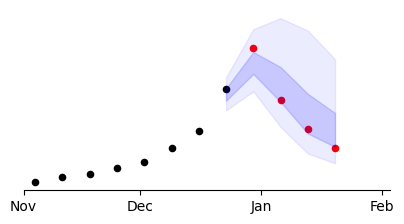

In [3]:
fig,ax=plt.subplots(figsize=(8.3/2, 11.7/5))

# visualise data
ax.scatter(data_train.index, data_train, marker='o', s=20, color='black')
ax.scatter(data_forecast.index, data_forecast, marker='o', s=20, color='red')
# visualise model
x = simout['target_end_date'].unique()
ax.fill_between(x, np.squeeze(simout[simout['output_type_id'] == 0.025][['value']].values),
                    np.squeeze(simout[simout['output_type_id'] == 1-0.025][['value']].values),
                       color='blue', alpha=0.075)
ax.fill_between(x, np.squeeze(simout[simout['output_type_id'] == 0.25][['value']].values),
                    np.squeeze(simout[simout['output_type_id'] == 0.75][['value']].values),
                       color='blue', alpha=0.15)
# no spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# months only
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# no ticks
ax.set_yticks([])
# xlims
ax.set_xlim([start_visualisation, stop_data_train+timedelta(weeks=6)])
plt.tight_layout()
plt.savefig(f'{filename[:-4]}.pdf')
plt.show()
plt.close()

## Whole-season fit figures

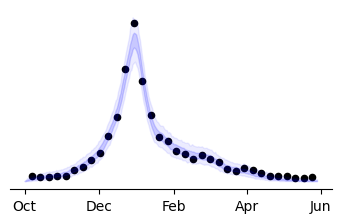

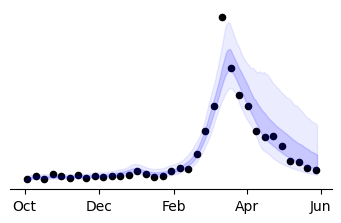

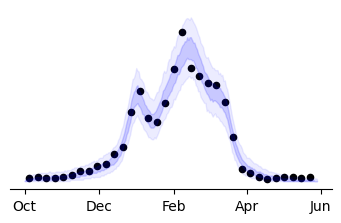

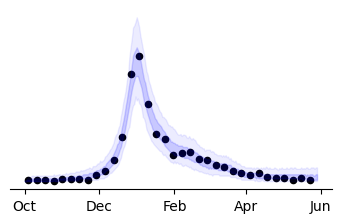

In [4]:
seasons = ['2014-2015', '2015-2016', '2019-2020', '2023-2024']
filenames = ['end-2024-04-06_simulation-output.nc',
             'end-2016-04-02_simulation-output.nc',
             'end-2020-04-04_simulation-output.nc',
             'end-2015-04-04_simulation-output.nc']
for season, filename in zip(seasons, filenames):
    # get simulation
    simout = xr.open_dataset(filename) * 7
    # get data
    data = get_NC_influenza_data(min(simout.date.values), max(simout.date.values), season)['H_inc']*7
    # make a figure
    fig,ax=plt.subplots(figsize=(8.3/2, 11.7/5))
    ## data
    ax.scatter(data.index, data, marker='o', s=20, color='black')
    ## model
    x = simout.date.values
    ax.fill_between(x, simout['H_inc'].sum(dim=['age_group', 'location']).quantile(q=0.025, dim='draws').values,
                        simout['H_inc'].sum(dim=['age_group', 'location']).quantile(q=1-0.025, dim='draws').values,
                           color='blue', alpha=0.075)
    ax.fill_between(x, simout['H_inc'].sum(dim=['age_group', 'location']).quantile(q=0.25, dim='draws').values,
                        simout['H_inc'].sum(dim=['age_group', 'location']).quantile(q=1-0.25, dim='draws').values,
                           color='blue', alpha=0.15)
    ## formatting
    # no spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # months only
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    # no ticks
    ax.set_yticks([])
    plt.savefig(f'{filename}.pdf')
    plt.show()
    plt.close()

## Incremental modifier fit

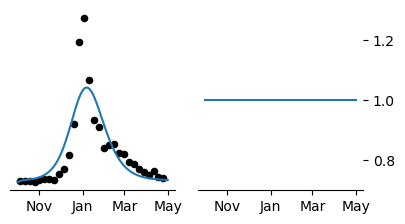

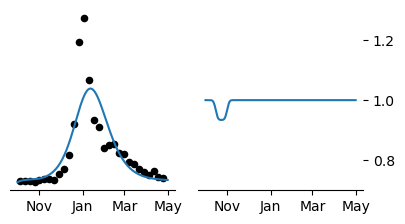

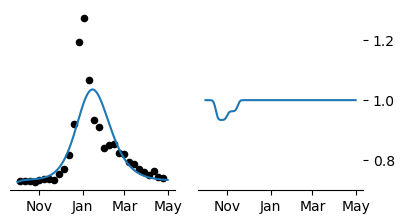

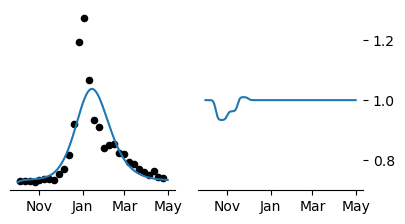

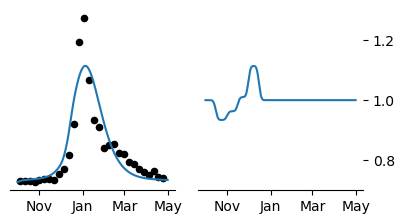

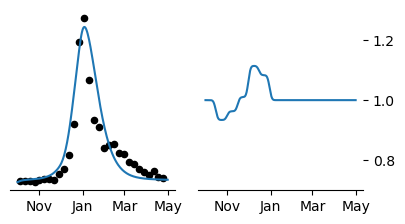

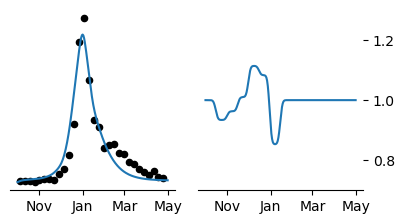

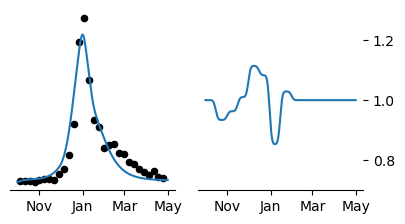

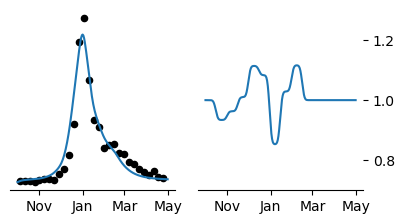

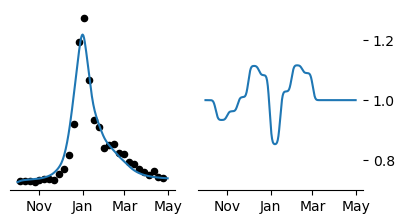

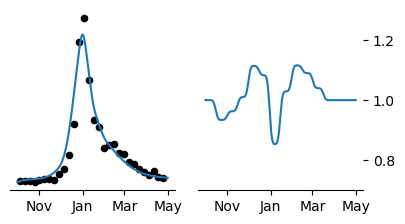

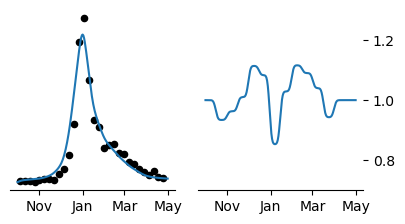

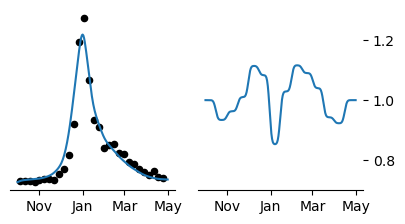

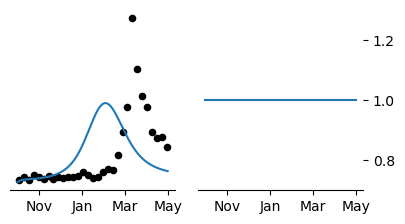

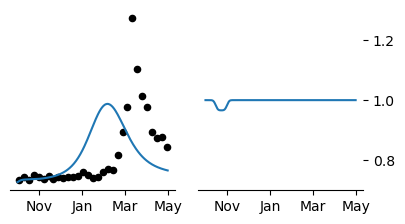

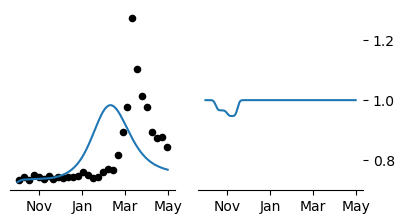

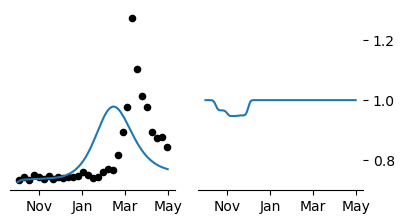

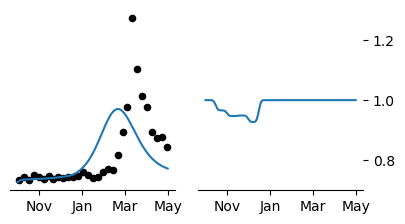

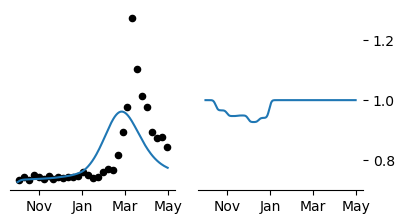

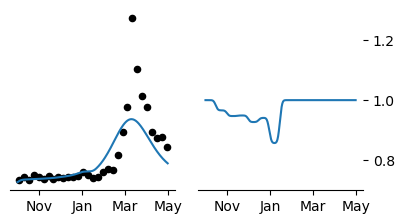

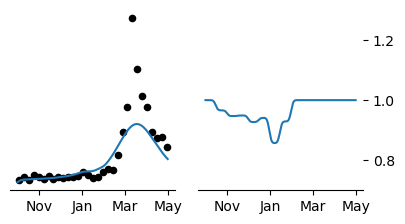

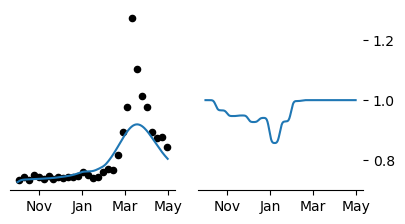

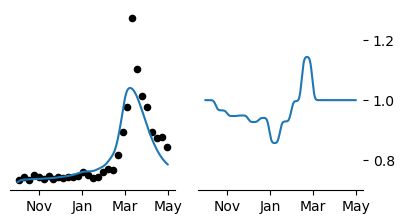

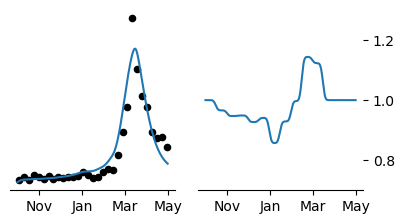

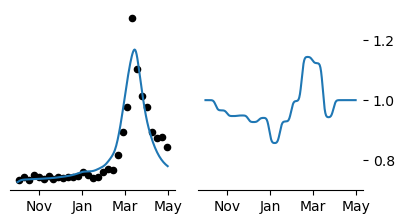

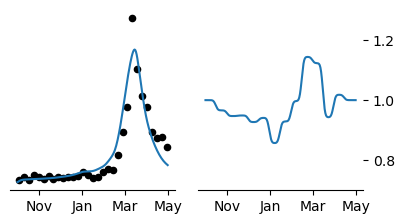

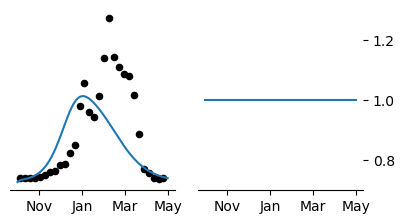

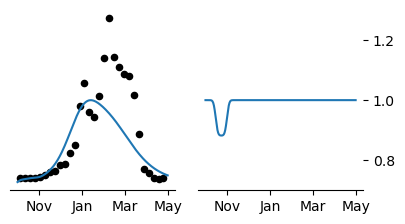

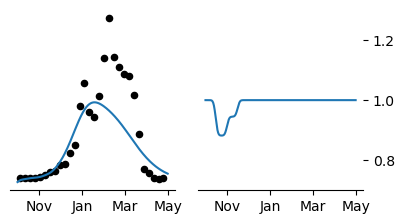

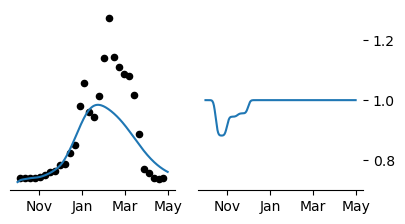

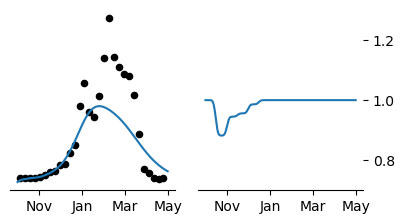

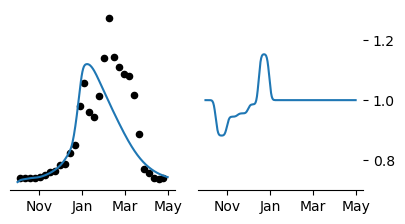

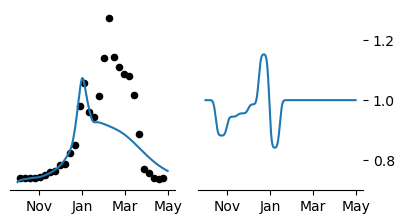

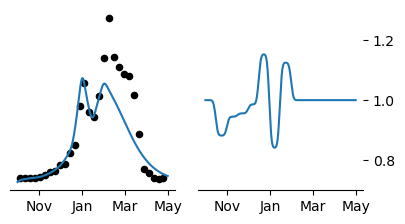

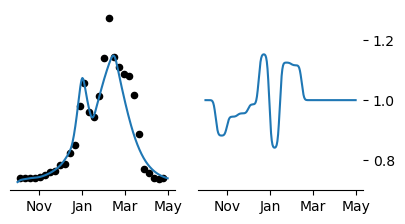

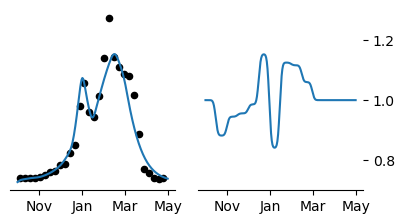

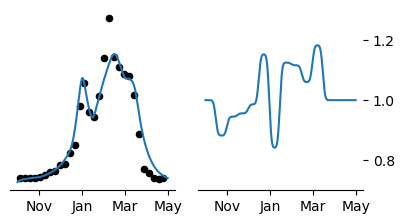

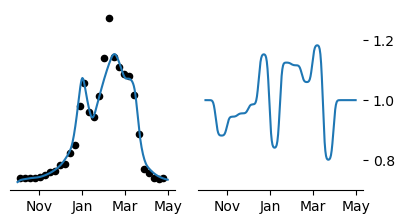

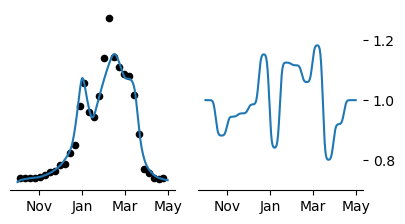

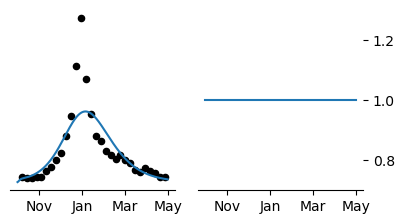

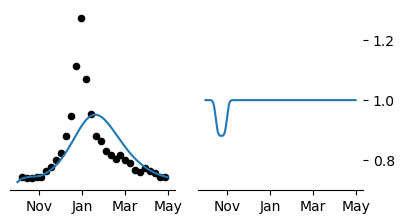

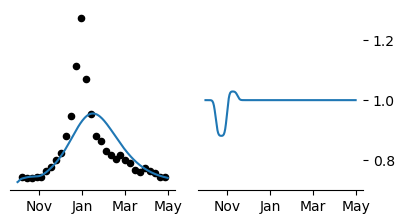

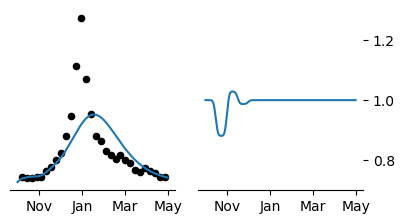

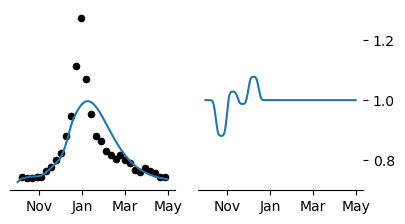

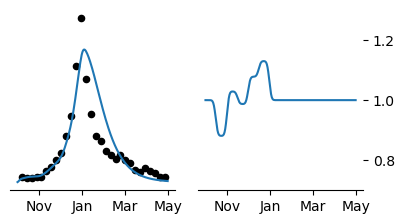

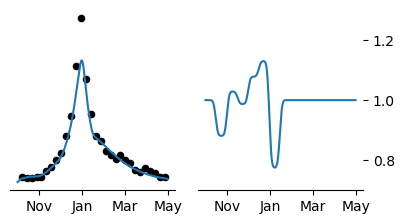

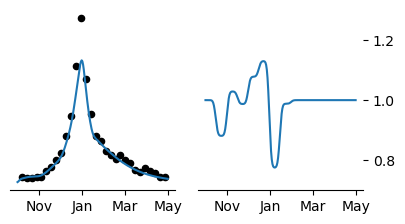

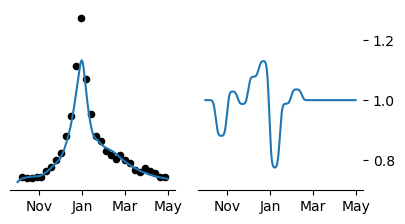

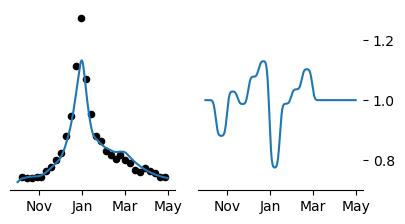

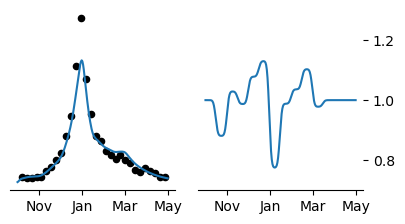

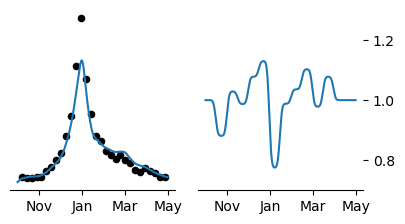

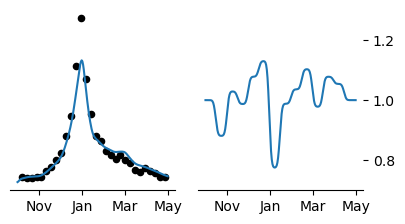

In [11]:
seasons = ['2014-2015', '2015-2016', '2019-2020', '2023-2024']

# loop over the seasons
for season in seasons:
    
    # load single strain model
    ## settings
    season_start = int(season[0:4])
    start_simulation = datetime(season_start, 10, 1)
    end_simulation = datetime(season_start+1, 5, 1)
    state = 'North Carolina'        
    sr = 'states'                                     
    ar = 'full'                                    
    dd = False                                  
                              
    ## load model
    from influenza_USA.NC_forecasts.utils import initialise_model  
    model = initialise_model(strains=True, spatial_resolution=sr, age_resolution=ar, state=state, season='average', distinguish_daytype=dd)
    
    # load dataset
    data = get_NC_influenza_data(start_simulation, end_simulation, season)['H_inc']
    
    # get independent fit parameters
    pars_model_0 = pd.read_csv('../../../../data/interim/calibration/single-season-optimal-parameters-sequentialTwoStrain.csv', index_col=0)[season].to_dict()
    
    # set parameters
    delta_beta_temporal = []
    for name, val in pars_model_0.items():
        if name.startswith("delta_beta_temporal_"):
            delta_beta_temporal.append(val)
        else:
            model.parameters[name] = val
    
    # loop over length of delta_beta_temporal
    for i in range(len(delta_beta_temporal)+1):
    
        # set right delta_beta_temporal
        if i == 0:
            pass
        else:
            model.parameters['delta_beta_temporal'][i-1] = delta_beta_temporal[i-1]
    
        # simulate model
        simout = model.sim([start_simulation, end_simulation])
        simout['H_inc'] = simout['H1_inc'] + simout['H2_inc']
        
        # Construct delta_beta_temporal trajectory
        
        # get function
        from influenza_USA.NC_forecasts.TDPF import transmission_rate_function
        f = transmission_rate_function(sigma=2.5)
        # pre-allocate output
        y = []
        x = pd.date_range(start=start_simulation, end=end_simulation, freq='d').tolist()
        # compute output
        for d in x:
            y.append(f(d, {}, 1, model.parameters['delta_beta_temporal'])[0])
        
        # make a figure
        fig,ax=plt.subplots(nrows=1, ncols=2, figsize=(8.3/2, 11.7/5))
        ## data
        ax[0].scatter(data.index, data, marker='o', s=20, color='black')
        ## model
        ax[0].plot(simout.date.values, simout['H_inc'].sum(dim=['age_group', 'location']))
        ## modifier trajectory
        ax[1].plot(x,y)
    
        ## formatting left axis
        # no spines
        ax[0].spines['top'].set_visible(False)
        ax[0].spines['right'].set_visible(False)
        ax[0].spines['left'].set_visible(False)
        # months only
        ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        # no ticks
        ax[0].set_yticks([])
        ## formatting right axis
        # no spines
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].spines['left'].set_visible(False)
        # months only
        ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        # no ticks
        ax[1].yaxis.tick_right()
        ax[1].set_yticks([0.8, 1, 1.2])
        ax[1].set_ylim([0.7, 1.3])
        plt.tight_layout()
        # save figure
        if not os.path.exists(f'{season}/'):
            os.makedirs(f'{season}/')
        plt.savefig(f'{season}/frame-{i}.png', dpi=200)
        plt.show()
        plt.close()